BEAM SEARCH vs GREEDY AGGLOMERATIVE CLUSTERING COMPARISON

Dataset: Well-separated Blobs
--------------------------------------------------
Greedy - Time: 0.2426s, Score: 5066.96
Beam-2 - Time: 549.1137s, Score: 5066.96, Speedup: 0.0x slower
Beam-3 - Time: 822.9709s, Score: 5066.96, Speedup: 0.0x slower
Beam-5 - Time: 1391.2678s, Score: 5066.96, Speedup: 0.0x slower


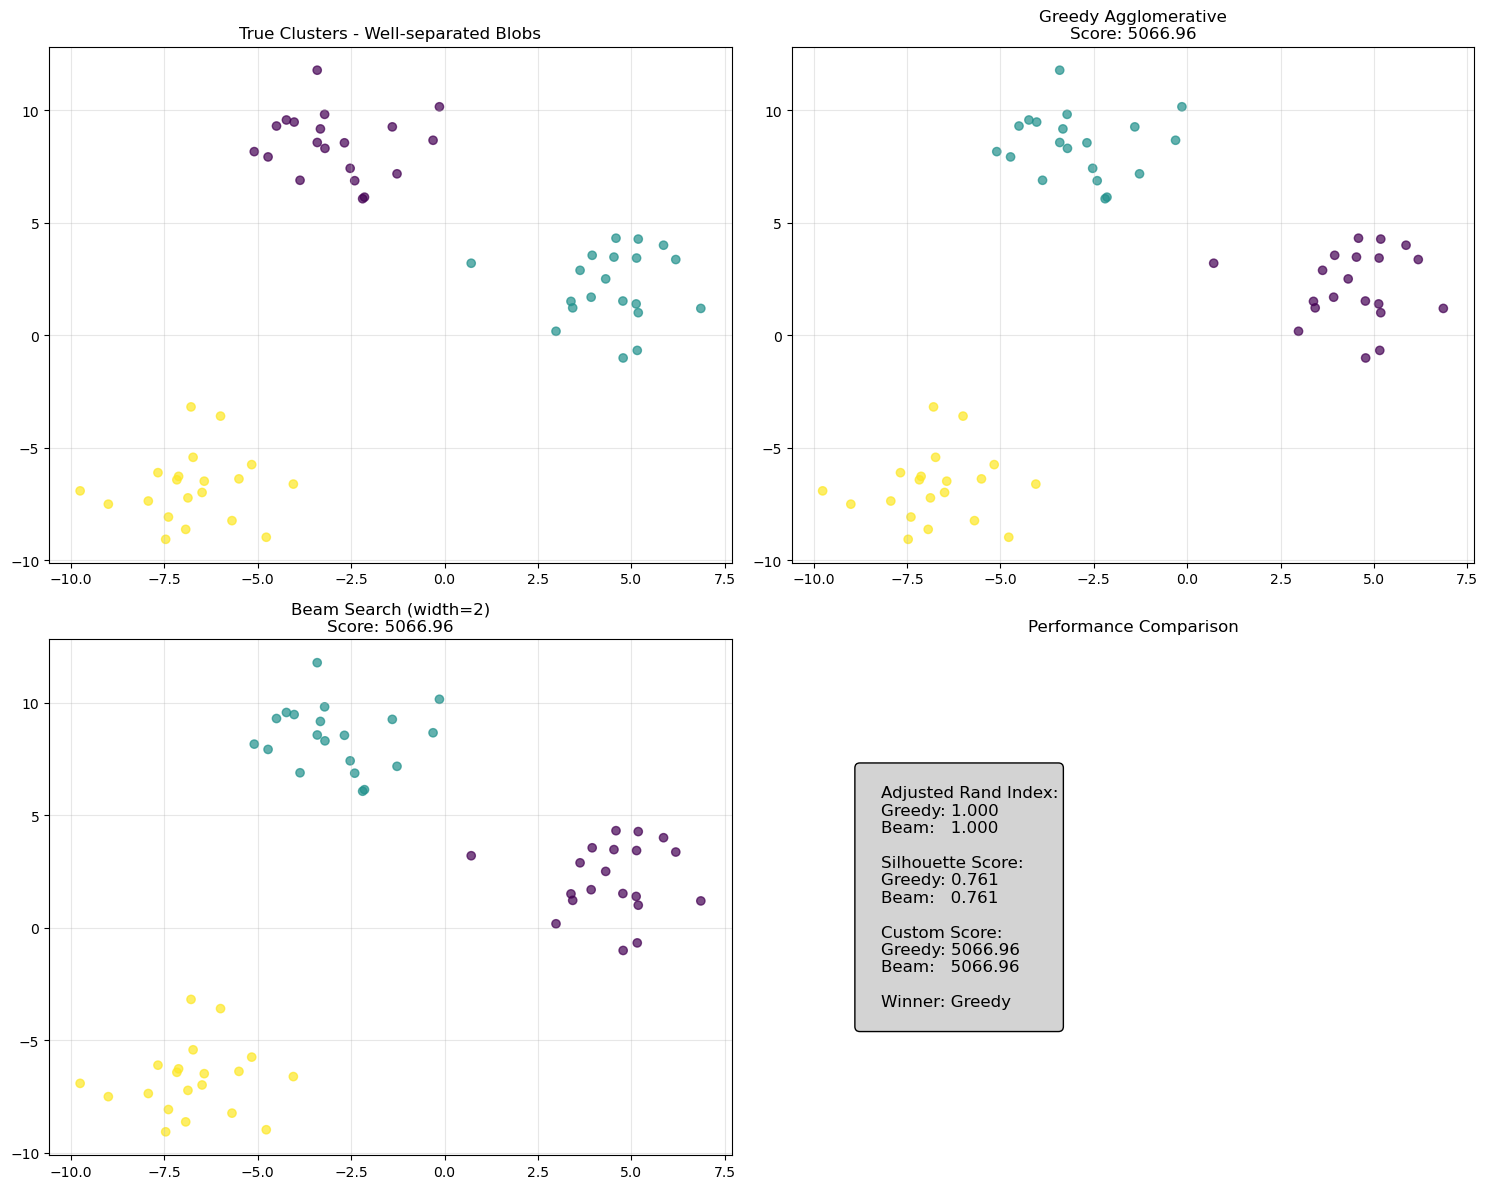

Best beam width: 2
Score improvement: +0.00
ARI improvement: +0.000

Dataset: Elongated Clusters
--------------------------------------------------
Greedy - Time: 0.2623s, Score: 2729.64
Beam-2 - Time: 3261.0372s, Score: 2981.02, Speedup: 0.0x slower
Beam-3 - Time: 825.4844s, Score: 2981.02, Speedup: 0.0x slower
Beam-5 - Time: 2997.4141s, Score: 2981.02, Speedup: 0.0x slower


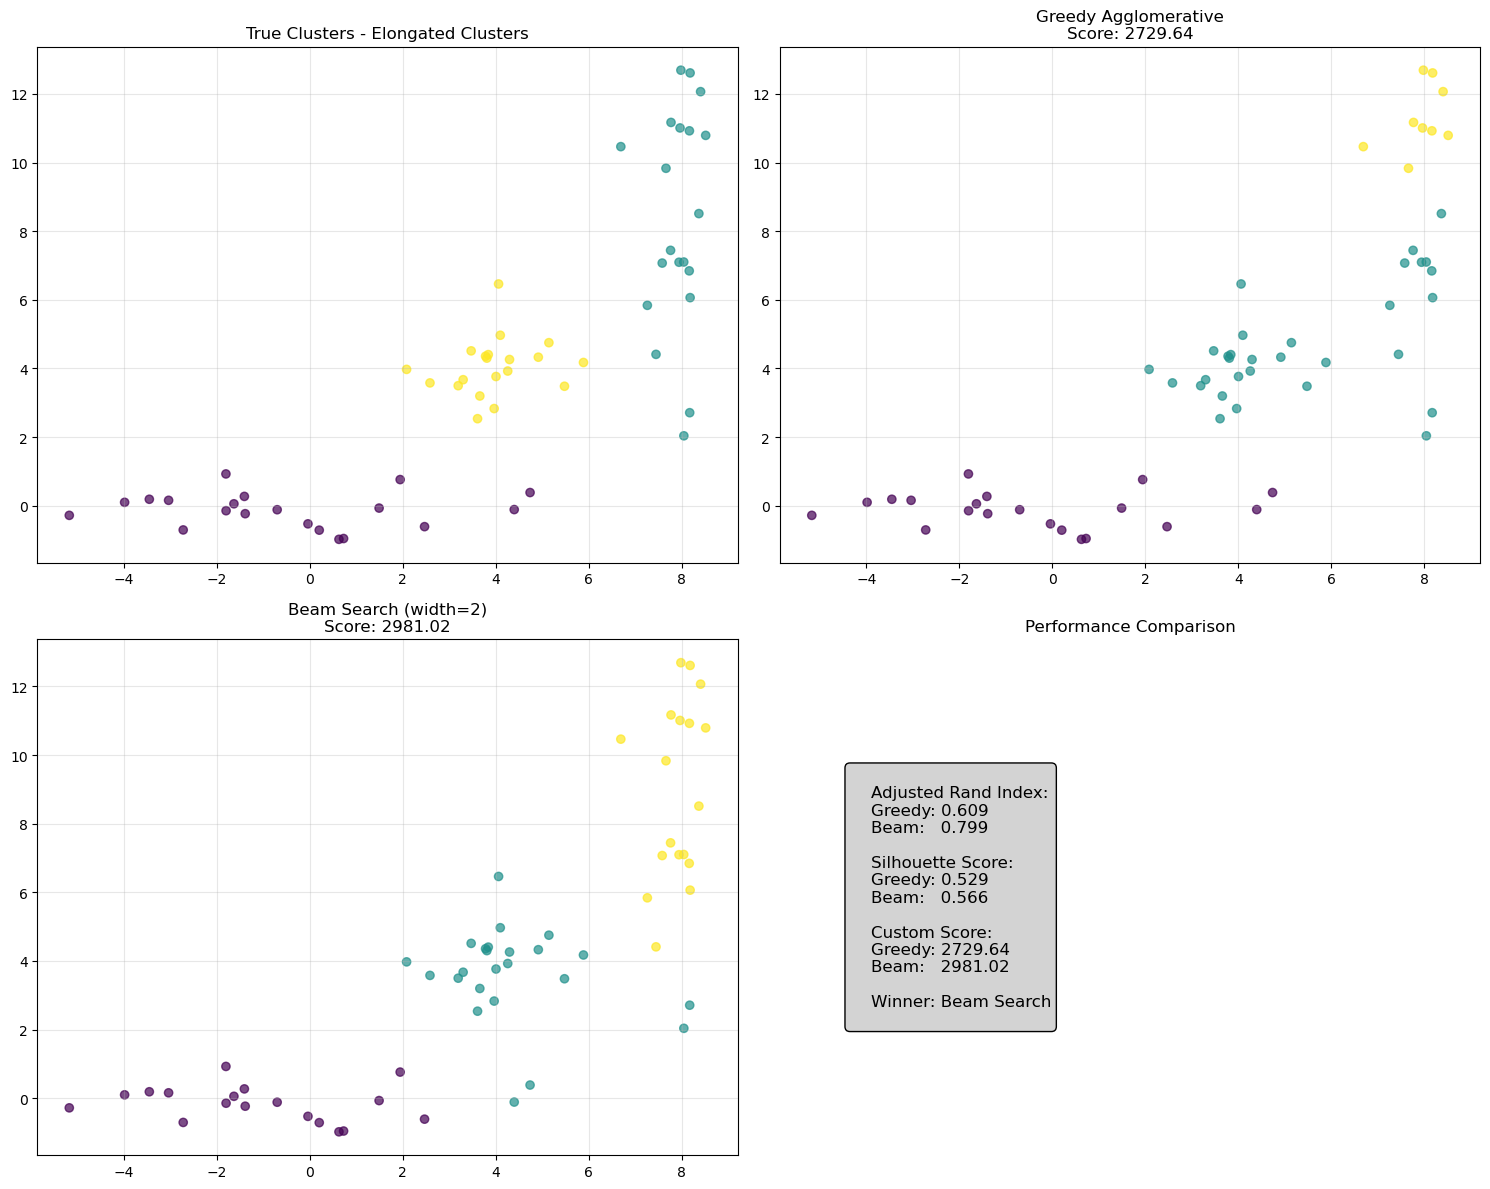

Best beam width: 2
Score improvement: +251.38
ARI improvement: +0.190

Dataset: Concentric Circles
--------------------------------------------------
Greedy - Time: 0.2491s, Score: 382.65
Beam-2 - Time: 6881.1695s, Score: 432.07, Speedup: 0.0x slower
Beam-3 - Time: 1127.7218s, Score: 432.07, Speedup: 0.0x slower
Beam-5 - Time: 12154.5583s, Score: 432.07, Speedup: 0.0x slower


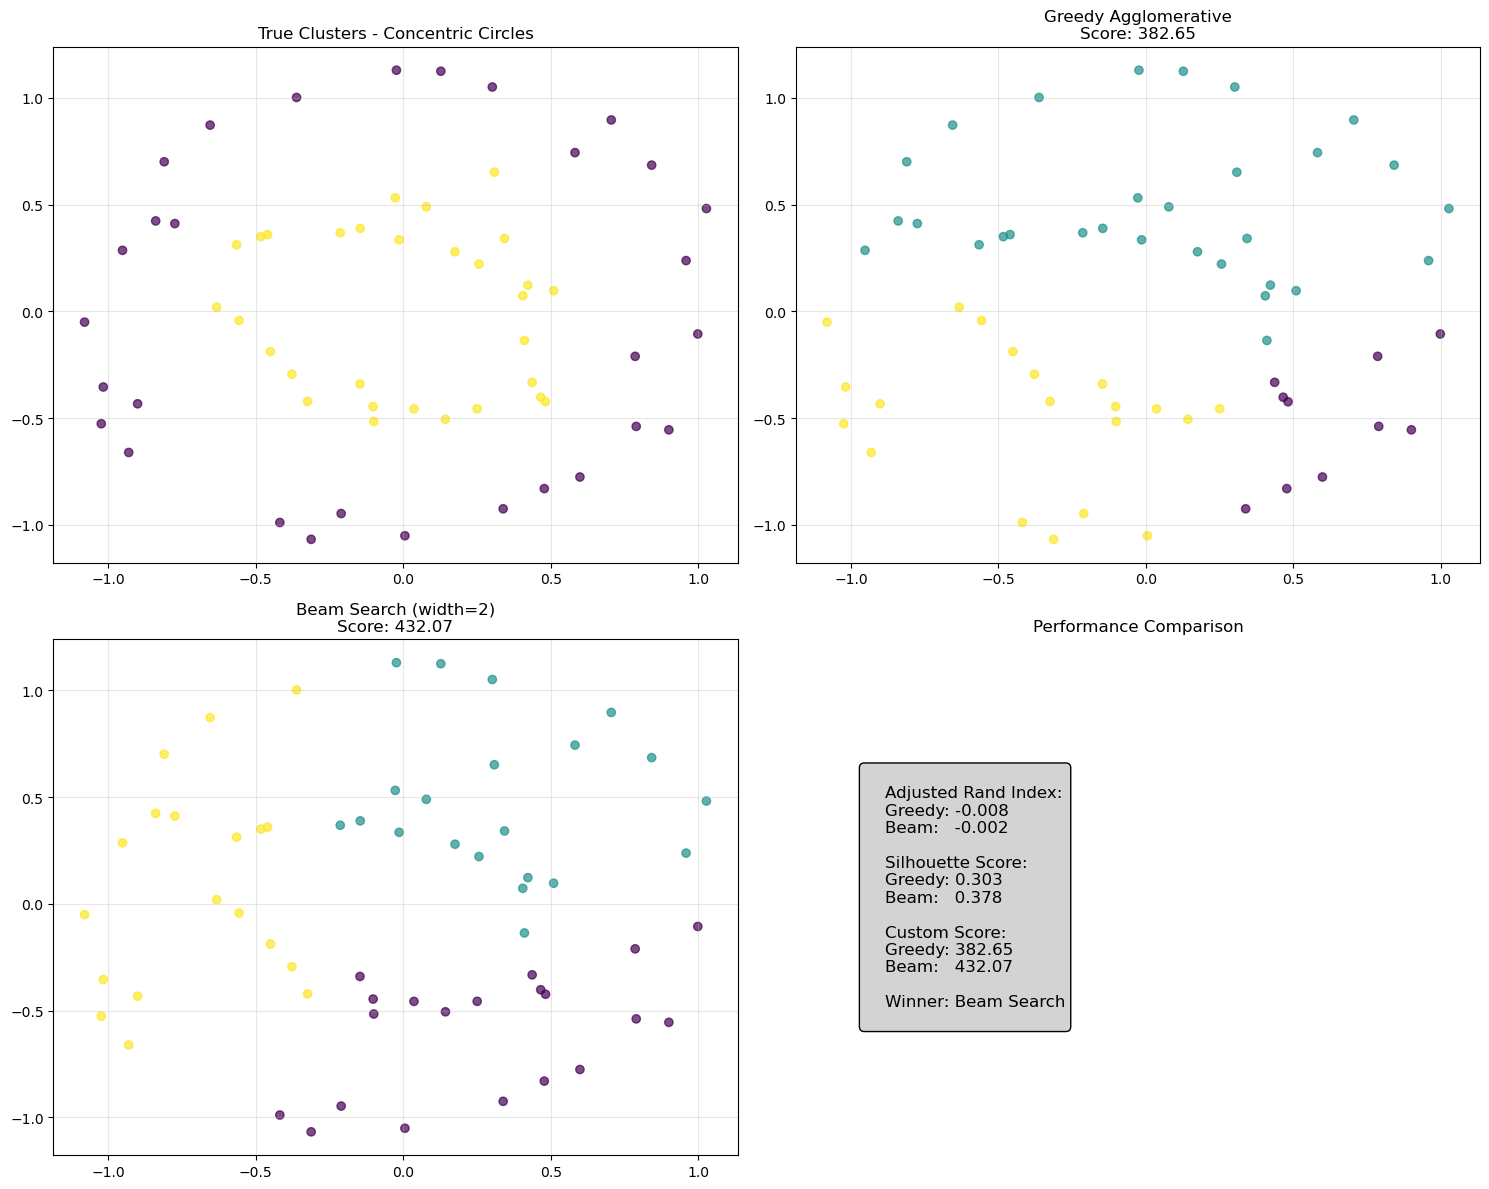

Best beam width: 2
Score improvement: +49.42
ARI improvement: +0.006

Dataset: Two Moons
--------------------------------------------------
Greedy - Time: 0.2536s, Score: 502.00
Beam-2 - Time: 536.4017s, Score: 545.98, Speedup: 0.0x slower
Beam-3 - Time: 780.2511s, Score: 545.98, Speedup: 0.0x slower
Beam-5 - Time: 1290.1815s, Score: 545.98, Speedup: 0.0x slower


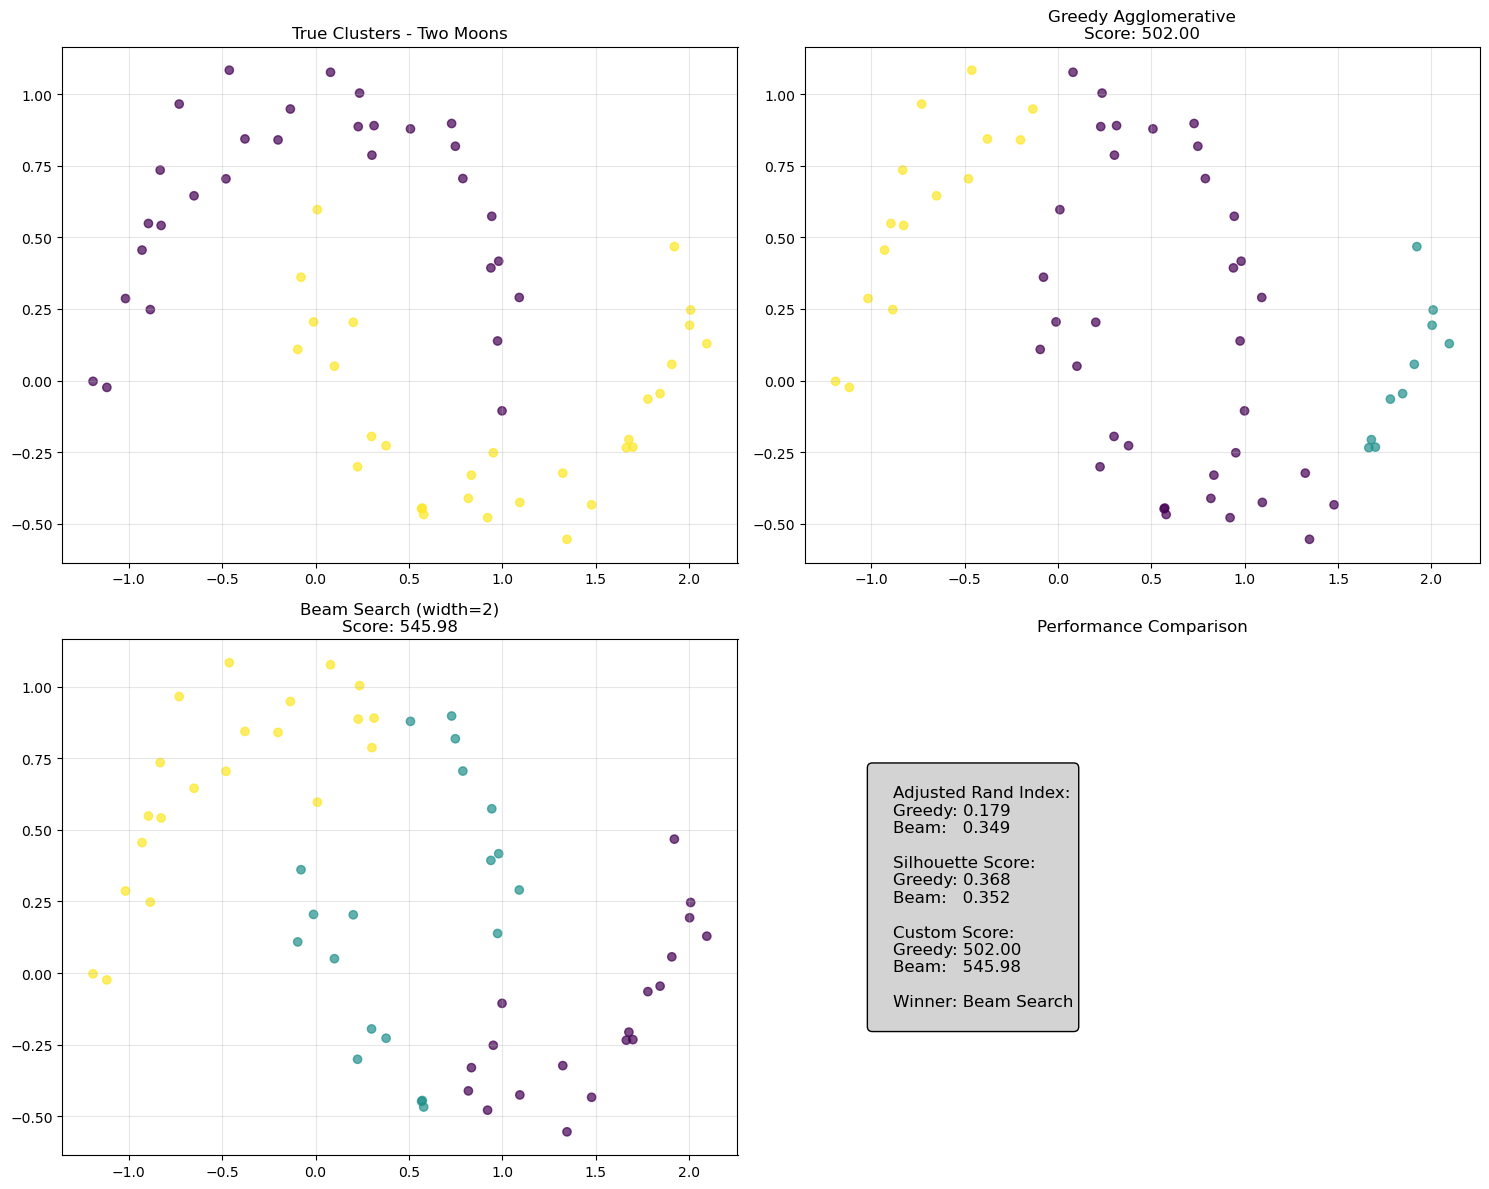

Best beam width: 2
Score improvement: +43.98
ARI improvement: +0.170

SUMMARY ANALYSIS
Average score improvement: +86.196
Average ARI improvement: +0.092
Datasets where beam search won: 3/4

KEY INSIGHTS
1. Beam search can escape local optima that trap greedy algorithms
2. Benefits are most pronounced on complex cluster shapes
3. Computational cost scales with beam width
4. Custom scoring function crucial for beam search success
5. Potential for hybrid approaches (beam early, greedy later)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.datasets import make_blobs, make_circles
import time
import copy
from typing import List, Tuple, Set
import heapq

class PartialClustering:
    """Represents a partial clustering state for beam search"""
    
    def __init__(self, clusters: List[Set[int]], data: np.ndarray):
        self.clusters = clusters
        self.data = data
        self.score = self._compute_score()
        self.n_clusters = len(clusters)
        
    def _compute_score(self) -> float:
        """Compute quality score for this partial clustering"""
        if len(self.clusters) <= 1:
            return 0
        
        # Multi-objective scoring: compactness + separation - complexity
        compactness = self._compute_compactness()
        separation = self._compute_separation()
        complexity_penalty = len(self.clusters) * 0.01  # Prefer fewer clusters
        
        return compactness + separation - complexity_penalty
    
    def _compute_compactness(self) -> float:
        """Within-cluster sum of squares (lower is better, so we negate)"""
        total_wcss = 0
        for cluster in self.clusters:
            if len(cluster) > 1:
                cluster_points = self.data[list(cluster)]
                centroid = cluster_points.mean(axis=0)
                wcss = np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
                total_wcss += wcss
        return -total_wcss
    
    def _compute_separation(self) -> float:
        """Between-cluster distances (higher is better)"""
        if len(self.clusters) <= 1:
            return 0
        
        centroids = []
        sizes = []
        for cluster in self.clusters:
            cluster_points = self.data[list(cluster)]
            centroids.append(cluster_points.mean(axis=0))
            sizes.append(len(cluster))
        
        centroids = np.array(centroids)
        total_separation = 0
        
        for i in range(len(centroids)):
            for j in range(i + 1, len(centroids)):
                dist = np.linalg.norm(centroids[i] - centroids[j])
                # Weight by cluster sizes
                weight = sizes[i] * sizes[j]
                total_separation += dist * weight
        
        return total_separation / len(self.clusters)
    
    def copy(self):
        """Create a deep copy of this clustering"""
        new_clusters = [cluster.copy() for cluster in self.clusters]
        return PartialClustering(new_clusters, self.data)
    
    def merge_clusters(self, i: int, j: int):
        """Merge clusters i and j"""
        if i > j:
            i, j = j, i  # Ensure i < j
        
        # Merge cluster j into cluster i
        self.clusters[i] = self.clusters[i].union(self.clusters[j])
        # Remove cluster j
        del self.clusters[j]
        # Recompute score
        self.score = self._compute_score()
        self.n_clusters = len(self.clusters)

class AgglomerativeClustering:
    """Base class for agglomerative clustering"""
    
    def __init__(self, linkage='average'):
        self.linkage = linkage
        
    def compute_distance_matrix(self, data: np.ndarray) -> np.ndarray:
        """Compute pairwise distances between points"""
        distances = pdist(data, metric='euclidean')
        return squareform(distances)
    
    def cluster_distance(self, cluster1: Set[int], cluster2: Set[int], 
                        distance_matrix: np.ndarray) -> float:
        """Compute distance between two clusters based on linkage criterion"""
        distances = [distance_matrix[i][j] for i in cluster1 for j in cluster2]
        
        if self.linkage == 'single':
            return min(distances)
        elif self.linkage == 'complete':
            return max(distances)
        elif self.linkage == 'average':
            return np.mean(distances)
        else:
            raise ValueError(f"Unknown linkage: {self.linkage}")

class GreedyAgglomerative(AgglomerativeClustering):
    """Traditional greedy agglomerative clustering"""
    
    def fit(self, data: np.ndarray, n_clusters: int = 2) -> PartialClustering:
        """Perform greedy agglomerative clustering"""
        # Initialize: each point is its own cluster
        clusters = [{i} for i in range(len(data))]
        distance_matrix = self.compute_distance_matrix(data)
        
        merge_history = []
        
        # Merge until we reach target number of clusters
        while len(clusters) > n_clusters:
            # Find closest pair of clusters
            min_dist = float('inf')
            merge_i, merge_j = -1, -1
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self.cluster_distance(clusters[i], clusters[j], distance_matrix)
                    if dist < min_dist:
                        min_dist = dist
                        merge_i, merge_j = i, j
            
            # Record merge
            merge_history.append((merge_i, merge_j, min_dist))
            
            # Perform merge (ensure i < j)
            if merge_i > merge_j:
                merge_i, merge_j = merge_j, merge_i
            
            clusters[merge_i] = clusters[merge_i].union(clusters[merge_j])
            del clusters[merge_j]
        
        result = PartialClustering(clusters, data)
        result.merge_history = merge_history
        return result

class BeamSearchAgglomerative(AgglomerativeClustering):
    """Beam search agglomerative clustering"""
    
    def __init__(self, linkage='average', beam_width=3):
        super().__init__(linkage)
        self.beam_width = beam_width
    
    def fit(self, data: np.ndarray, n_clusters: int = 2) -> PartialClustering:
        """Perform beam search agglomerative clustering"""
        # Initialize: each point is its own cluster
        initial_clusters = [{i} for i in range(len(data))]
        beam = [PartialClustering(initial_clusters, data)]
        distance_matrix = self.compute_distance_matrix(data)
        
        # Continue until all clusterings in beam reach target size
        while any(clustering.n_clusters > n_clusters for clustering in beam):
            new_candidates = []
            
            for clustering in beam:
                if clustering.n_clusters <= n_clusters:
                    new_candidates.append(clustering)
                    continue
                
                # Generate all possible merges for this clustering
                for i in range(len(clustering.clusters)):
                    for j in range(i + 1, len(clustering.clusters)):
                        # Create new clustering with this merge
                        new_clustering = clustering.copy()
                        new_clustering.merge_clusters(i, j)
                        new_candidates.append(new_clustering)
            
            # Keep only top beam_width candidates
            if len(new_candidates) > self.beam_width:
                new_candidates.sort(key=lambda x: x.score, reverse=True)
                beam = new_candidates[:self.beam_width]
            else:
                beam = new_candidates
        
        # Return best clustering from final beam
        beam.sort(key=lambda x: x.score, reverse=True)
        return beam[0]

def generate_synthetic_data(dataset_type='blobs', n_samples=50, noise=0.1):
    """Generate synthetic datasets for testing"""
    np.random.seed(42)
    
    if dataset_type == 'blobs':
        X, y_true = make_blobs(n_samples=n_samples, centers=3, n_features=2, 
                              random_state=42, cluster_std=1.5)
    elif dataset_type == 'circles':
        X, y_true = make_circles(n_samples=n_samples, noise=noise, factor=0.5, 
                                random_state=42)
    elif dataset_type == 'moons':
        from sklearn.datasets import make_moons
        X, y_true = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    elif dataset_type == 'elongated':
        # Create elongated clusters that might trip up greedy algorithms
        cluster1 = np.random.normal([0, 0], [3, 0.5], (n_samples//3, 2))
        cluster2 = np.random.normal([8, 8], [0.5, 3], (n_samples//3, 2))
        cluster3 = np.random.normal([4, 4], [1, 1], (n_samples//3, 2))
        X = np.vstack([cluster1, cluster2, cluster3])
        y_true = np.hstack([np.zeros(n_samples//3), np.ones(n_samples//3), 
                           np.full(n_samples//3, 2)])
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")
    
    return X, y_true

def visualize_clustering_comparison(X, y_true, greedy_result, beam_result, 
                                  dataset_name, beam_width):
    """Visualize the comparison between greedy and beam search clustering"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # True clusters
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    axes[0, 0].set_title(f'True Clusters - {dataset_name}')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Greedy clustering
    greedy_labels = np.zeros(len(X))
    for i, cluster in enumerate(greedy_result.clusters):
        for point in cluster:
            greedy_labels[point] = i
    
    axes[0, 1].scatter(X[:, 0], X[:, 1], c=greedy_labels, cmap='viridis', alpha=0.7)
    axes[0, 1].set_title(f'Greedy Agglomerative\nScore: {greedy_result.score:.2f}')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Beam search clustering
    beam_labels = np.zeros(len(X))
    for i, cluster in enumerate(beam_result.clusters):
        for point in cluster:
            beam_labels[point] = i
    
    axes[1, 0].scatter(X[:, 0], X[:, 1], c=beam_labels, cmap='viridis', alpha=0.7)
    axes[1, 0].set_title(f'Beam Search (width={beam_width})\nScore: {beam_result.score:.2f}')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparison metrics
    greedy_ari = adjusted_rand_score(y_true, greedy_labels)
    beam_ari = adjusted_rand_score(y_true, beam_labels)
    
    if len(np.unique(greedy_labels)) > 1:
        greedy_sil = silhouette_score(X, greedy_labels)
    else:
        greedy_sil = 0
        
    if len(np.unique(beam_labels)) > 1:
        beam_sil = silhouette_score(X, beam_labels)
    else:
        beam_sil = 0
    
    # Metrics comparison
    metrics_text = f"""
    Adjusted Rand Index:
    Greedy: {greedy_ari:.3f}
    Beam:   {beam_ari:.3f}
    
    Silhouette Score:
    Greedy: {greedy_sil:.3f}
    Beam:   {beam_sil:.3f}
    
    Custom Score:
    Greedy: {greedy_result.score:.2f}
    Beam:   {beam_result.score:.2f}
    
    Winner: {'Beam Search' if beam_result.score > greedy_result.score else 'Greedy'}
    """
    
    axes[1, 1].text(0.1, 0.5, metrics_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Performance Comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'greedy_ari': greedy_ari,
        'beam_ari': beam_ari,
        'greedy_sil': greedy_sil,
        'beam_sil': beam_sil,
        'greedy_score': greedy_result.score,
        'beam_score': beam_result.score
    }

def run_comprehensive_comparison():
    """Run comprehensive comparison across multiple datasets and beam widths"""
    datasets = [
        ('blobs', 'Well-separated Blobs'),
        ('elongated', 'Elongated Clusters'), 
        ('circles', 'Concentric Circles'),
        ('moons', 'Two Moons')
    ]
    
    beam_widths = [2, 3, 5]
    n_clusters = 3
    results = []
    
    print("="*80)
    print("BEAM SEARCH vs GREEDY AGGLOMERATIVE CLUSTERING COMPARISON")
    print("="*80)
    
    for dataset_type, dataset_name in datasets:
        print(f"\nDataset: {dataset_name}")
        print("-" * 50)
        
        # Generate data
        X, y_true = generate_synthetic_data(dataset_type, n_samples=60)
        
        # Greedy clustering
        start_time = time.time()
        greedy_clusterer = GreedyAgglomerative(linkage='average')
        greedy_result = greedy_clusterer.fit(X, n_clusters=n_clusters)
        greedy_time = time.time() - start_time
        
        print(f"Greedy - Time: {greedy_time:.4f}s, Score: {greedy_result.score:.2f}")
        
        # Test different beam widths
        best_beam_result = None
        best_beam_width = None
        
        for beam_width in beam_widths:
            start_time = time.time()
            beam_clusterer = BeamSearchAgglomerative(linkage='average', 
                                                   beam_width=beam_width)
            beam_result = beam_clusterer.fit(X, n_clusters=n_clusters)
            beam_time = time.time() - start_time
            
            print(f"Beam-{beam_width} - Time: {beam_time:.4f}s, Score: {beam_result.score:.2f}, "
                  f"Speedup: {greedy_time/beam_time:.1f}x slower")
            
            if best_beam_result is None or beam_result.score > best_beam_result.score:
                best_beam_result = beam_result
                best_beam_width = beam_width
        
        # Visualize best beam search vs greedy
        metrics = visualize_clustering_comparison(X, y_true, greedy_result, 
                                                best_beam_result, dataset_name, 
                                                best_beam_width)
        
        improvement = best_beam_result.score - greedy_result.score
        print(f"Best beam width: {best_beam_width}")
        print(f"Score improvement: {improvement:+.2f}")
        print(f"ARI improvement: {metrics['beam_ari'] - metrics['greedy_ari']:+.3f}")
        
        results.append({
            'dataset': dataset_name,
            'improvement': improvement,
            'best_beam_width': best_beam_width,
            'greedy_time': greedy_time,
            **metrics
        })
    
    # Summary analysis
    print("\n" + "="*80)
    print("SUMMARY ANALYSIS")
    print("="*80)
    
    improvements = [r['improvement'] for r in results]
    ari_improvements = [r['beam_ari'] - r['greedy_ari'] for r in results]
    
    print(f"Average score improvement: {np.mean(improvements):+.3f}")
    print(f"Average ARI improvement: {np.mean(ari_improvements):+.3f}")
    print(f"Datasets where beam search won: {sum(1 for imp in improvements if imp > 0)}/{len(improvements)}")
    
    return results

if __name__ == "__main__":
    # Run the comprehensive comparison
    results = run_comprehensive_comparison()
    
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    print("1. Beam search can escape local optima that trap greedy algorithms")
    print("2. Benefits are most pronounced on complex cluster shapes")
    print("3. Computational cost scales with beam width")
    print("4. Custom scoring function crucial for beam search success")
    print("5. Potential for hybrid approaches (beam early, greedy later)")